# Digit Classification

## 1. Import library

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

## 2. Get the MNIST dataset

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
BATCH_SIZE = 64

# Create dataloader
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in test_dl:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


Device agnostic code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 3. Create model

In [5]:
class MyFirstCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [6]:
cnn_model0 = MyFirstCNN().to(device)

In [7]:
class MySecondCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( # 1*28*28
            nn.Conv2d(kernel_size=3,
                      in_channels=1,
                      out_channels=8), # 8*26*26
            nn.MaxPool2d(kernel_size=2), # 8*13*13
            nn.Conv2d(kernel_size=3,
                      in_channels=8,
                      out_channels=16), # 16*11*11
            nn.MaxPool2d(kernel_size=2), # 16*5*5
            nn.Flatten(),
            nn.Linear(16*5*5, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

In [8]:
cnn_model2 = MySecondCNN().to(device)

In [9]:
class MyFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
class Lernet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( # 1*28*28
            nn.Conv2d(kernel_size=5,
                      in_channels=1,
                      out_channels=6), # 6*24*24
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # 6*12*12
            nn.Conv2d(kernel_size=5,
                      in_channels=6,
                      out_channels=16), # 16*8*8
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # 16*4*4
            MyFlatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

lernet_model = Lernet5().to(device)

# 4. Define loss and optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lernet_model.parameters(),
                            lr=1e-3)

# 5. Create train and test step

In [12]:
import torch.utils
import torch.utils.data


def train_step(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = "cpu"):
    size = len(dataloader.dataset)
    
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        # 1. Forward
        logits = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(logits, y)
        total_loss += loss
        
        # 3. Backpropagation
        loss.backward()
        
        # 4. Optimizer step
        optimizer.step()
        
        # 5. Zero grad
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= len(dataloader)
    return total_loss

def test_step(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn,
               device: torch.device = "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
        
        

# 6.Train the model

In [71]:
epochs = 20
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_step(dataloader=train_dl,
                            model=lernet_model,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
    test_loss, accuracy = test_step(dataloader=test_dl,
                            model=lernet_model,
                            loss_fn=loss_fn,
                            device=device)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306656  [   64/60000]
loss: 2.294912  [ 6464/60000]
loss: 2.306729  [12864/60000]
loss: 2.296845  [19264/60000]
loss: 2.311276  [25664/60000]
loss: 2.305921  [32064/60000]
loss: 2.305851  [38464/60000]
loss: 2.306609  [44864/60000]
loss: 2.302669  [51264/60000]
loss: 2.293748  [57664/60000]
Test Error: 
 Accuracy: 11.6%, Avg loss: 2.300711 

Epoch 2
-------------------------------
loss: 2.302303  [   64/60000]
loss: 2.291965  [ 6464/60000]
loss: 2.303299  [12864/60000]
loss: 2.294426  [19264/60000]
loss: 2.307545  [25664/60000]
loss: 2.303183  [32064/60000]
loss: 2.301013  [38464/60000]
loss: 2.304334  [44864/60000]
loss: 2.299882  [51264/60000]
loss: 2.290132  [57664/60000]
Test Error: 
 Accuracy: 16.8%, Avg loss: 2.297288 

Epoch 3
-------------------------------
loss: 2.298337  [   64/60000]
loss: 2.288864  [ 6464/60000]
loss: 2.299785  [12864/60000]
loss: 2.291998  [19264/60000]
loss: 2.303852  [25664/60000]
loss: 2.300149  [32064/600

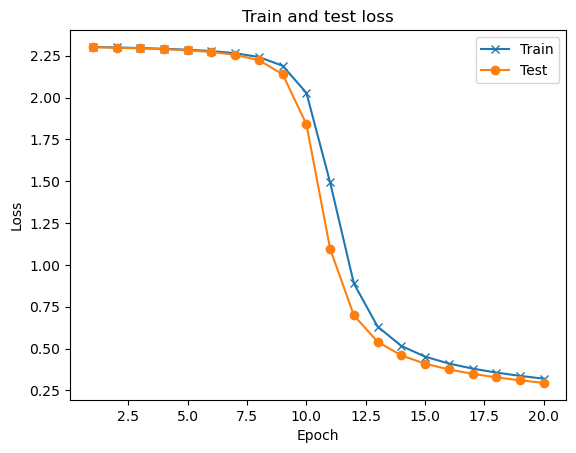

In [73]:
import matplotlib.pyplot as plt
import numpy as np
train_loss_history_tensor = torch.Tensor(train_loss_history).cpu()
test_loss_history_tensor = torch.Tensor(test_loss_history).cpu()
plt.plot(np.arange(1,epochs+1), train_loss_history_tensor, marker='x')
plt.plot(np.arange(1,epochs+1), test_loss_history_tensor, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss")
plt.legend(["Train", "Test"])

Text(0.5, 1.0, 'Test accuracy')

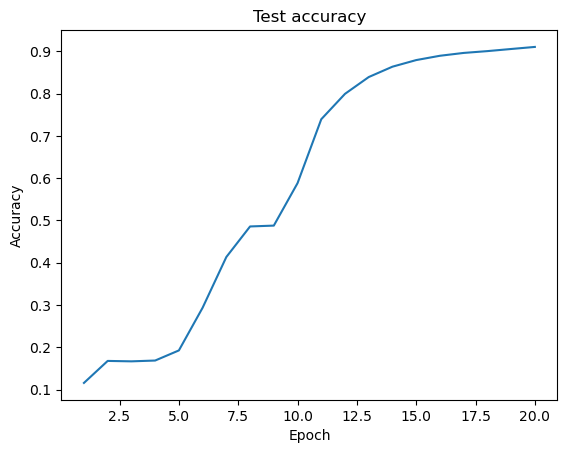

In [74]:
test_accuracy_history_tensor = torch.Tensor(test_accuracy_history).cpu()
plt.plot(np.arange(1,epochs+1), test_accuracy_history_tensor)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test accuracy")

# 7. Save models

In [13]:
torch.save(lernet_model.state_dict(), "lernet5_model.pth")
print("saved Pytorch model state to the lernet5_model.pth")

saved Pytorch model state to the lernet5_model.pth


# 8. Loading models

In [8]:
model = MySecondCNN().to(device)
model.load_state_dict(torch.load("cnn_model2.pth", weights_only=True))

<All keys matched successfully>

In [9]:
print(model)

MySecondCNN(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=400, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [10]:
model.eval()
idx = 30

x, y = test_data[idx][0], test_data[idx][1]

x = x[np.newaxis, :]

with torch.inference_mode():
    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0].argmax(0), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "3", Actual: "3"


Text(0.5, 1.0, 'Prediction: 3')

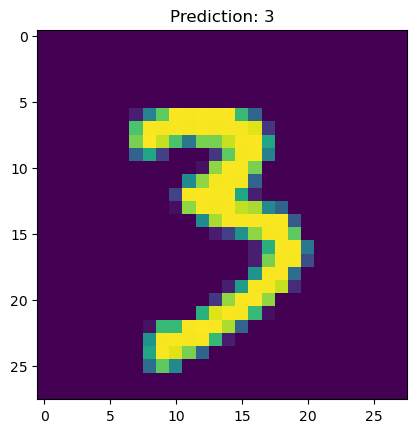

In [11]:
from PIL import Image
plt.imshow(x[0].reshape(28,28,1))
plt.title(f"Prediction: {predicted}")

# 9. Plot feature map

In [12]:
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []

# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            if type(model_children[i][j]) == nn.Conv2d:
                counter+=1
                model_weights.append(model_children[i][j].weight)
                conv_layers.append(model_children[i][j])
print(f"Total convolution layers: {counter}")
print("conv_layers")


Total convolution layers: 2
conv_layers


In [13]:
outputs = []
names = []
image = x
for layer in conv_layers:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

2
torch.Size([1, 8, 26, 26])
torch.Size([1, 16, 24, 24])


In [14]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(26, 26)
(24, 24)


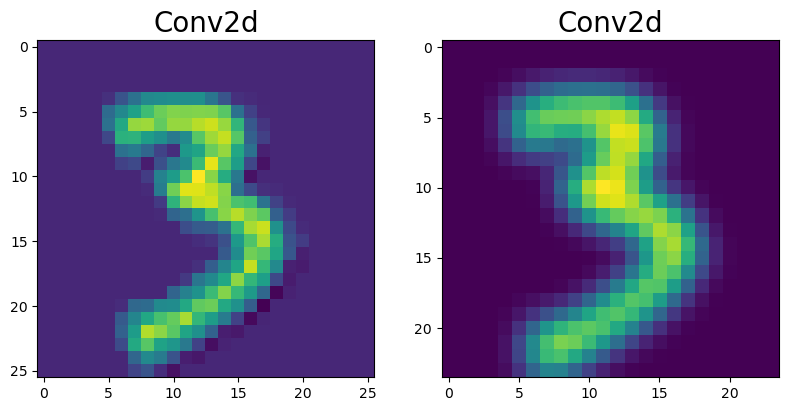

In [15]:
fig = plt.figure(figsize=(20, 30))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    #a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=20)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')